## Google Cloud Natural Language API
Today's blog post is a hands-on demo and evaluation of the [Google Cloud Natural Language API](https://cloud.google.com/natural-language/).  Like *all* cherry picked examples/demos, their site shows an impressive result in the system's ability to do entity identification, sentiment analysis, and extract syntax.  How will the results be on a real world dataset?

As I've done previously, I'm going to use the episode short descriptions found in the Data Skeptic RSS feed.  At times, we've done extensive write ups, while for other episodes, these are terse and written at the last minute.  While we're striving to improve these with time, the older ones are admittedly not as good.  Let's keep that in mind as we evaluate.

This API allows a fairly generous free tier of 5k requests per month.  Requests beyond this are cheap enough that a graduate student could easily afford using it for their research.  At the time of writing this, it's $0.01 per use from 5k-1M requests, and progressively discounted after that.

You will, however, need to take a few steps including enabling billing, as description in the [Quickstart](https://cloud.google.com/natural-language/docs/getting-started).

While there are some Python wrapper libraries, I found them infuriatingly difficult to install and use.  I spent more time trying to get it working than to just code it directly via the RESTful API, so that's what I did in the code below.

### Get all episode descriptions as a list of strings

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import requests
import xmltodict
import json
import pandas as pd
import pickle
from bs4 import BeautifulSoup

In [2]:
# Get all the descriptions

fname = 'feed.xml'
url = 'http://dataskeptic.com/feed.rss'

if not(os.path.isfile(fname)):
    r = requests.get(url)
    f = open(fname, 'wb')
    f.write(r.text.encode('utf-8'))
    f.close()

with open(fname) as fd:
    xml = xmltodict.parse(fd.read())

episodes = xml['rss']['channel']['item']
descriptions = []
descToTitle = {}
descToNum = {}
l = len(episodes)
for episode in episodes:
    enclosure = episode['enclosure']
    desc = episode['description']
    desc = BeautifulSoup(desc, "lxml").text
    descriptions.append(desc)
    descToTitle[desc] = episode['title']
    descToNum[desc] = l
    l = l - 1

In [3]:
len(descriptions)

173

### Let's do a quick test of a simple sentence

In [49]:
sentence = 'Data Skeptic is a podcast hosted by Kyle Polich.'

In [50]:
api_key = json.load(open('gcloud-lang-api-key.json', 'r'))['api_key']

In [51]:
url = "https://language.googleapis.com/v1/documents:analyzeEntities?key={api_key}".format(api_key=api_key)

In [52]:
payload = {
  "encodingType": "UTF8",
  "document": {
    "type": "PLAIN_TEXT",
    "content": sentence
  }
}

In [53]:
r = requests.post(url, data=json.dumps(payload))

In [54]:
r.status_code

200

In [55]:
json.loads(r.content.decode('utf-8'))

{'entities': [{'mentions': [{'text': {'beginOffset': 0,
      'content': 'Data Skeptic'},
     'type': 'PROPER'},
    {'text': {'beginOffset': 18, 'content': 'podcast'}, 'type': 'COMMON'}],
   'metadata': {},
   'name': 'Data Skeptic',
   'salience': 0.91002035,
   'type': 'WORK_OF_ART'},
  {'mentions': [{'text': {'beginOffset': 36, 'content': 'Kyle Polich'},
     'type': 'PROPER'}],
   'metadata': {},
   'name': 'Kyle Polich',
   'salience': 0.089979626,
   'type': 'PERSON'}],
 'language': 'en'}

### Observations
Looks good!  It identified two key ideas in this sentence.  Granted, a simple rule looking at capitalization would have been good enough to recognize the two important entities in the sentence.  It is yet to be seen how well the API performs identifying entities since this is an easy test.  Yet, notice how Data Skeptic is labeled as a "Work of Art" (thanks Google!) and Kyle Polich is labeled as a person, which only a few people have doubted to be true.

Now, let's retrieve all the results for the podcast descriptions.

In [80]:
results = {}
for desc in descriptions:
    if desc not in results:
        payload = {
          "encodingType": "UTF8", "document": {
            "type": "PLAIN_TEXT", "content": desc }
        }
        r = requests.post(url, data=json.dumps(payload))
        if r.status_code == 200:
            results[desc] = json.loads(r.content.decode('utf-8'))
        else:
            print("ERROR with desc: " + desc)

In [81]:
pickle.dump(results, open('results.pickle', 'wb'))

In [131]:
# In the next section we'll use this function to extact data into a more useful data structure

def extract_entities_as_rows(r):
    rows = []
    entities = r['entities']
    for entity in entities:
        mentions = entity['mentions']
        if 'wikipedia_url' in entity['metadata']:
            wiki = entity['metadata']['wikipedia_url']
        else:
            wiki = ''
        row = {
            "num_mentions": len(entity),
            "wiki_url": wiki,
            "name": entity['name'],
            "salience": entity['salience'],
            "type": entity['type']
        }
        rows.append(row)
    return rows

###   Now let's analyze the results!

Let's take a totally arbitrary example and expore it.  I picked the episode we did on PageRank.  Below are the entities that were extracted, sorted by salience descending.  Ideally, the most important/relevant concepts are ranked near the top.  It definitely gets PageRank correct as the top concept.

Beyond that the ordering is a bit mediocre, yet it's interesting to observe that the `wiki_url` is well mapped.  I noticed that "search engine" which *could* have been linked to some very generic wikipedia page is not.  I see this as a win.  Of the four Wiki links provided, this anacdote has a 100% match rate.  This gets me thinking about what I might do in the future taking these matches and linking them to the Wikipedia Knowledge Graph.

In [136]:
key = list(results.keys())[0]
print(key)

PageRank is the algorithm most famous for being one of the original innovations that made Google stand out as a search engine. It was defined in the classic paper The Anatomy of a Large-Scale Hypertextual Web Search Engine by Sergey Brin and Larry Page. While this algorithm clearly impacted web searching, it has also been useful in a variety of other applications. This episode presents a high level description of this algorithm and how it might apply when trying to establish who writes the most influencial academic papers.


In [137]:
pd.DataFrame(extract_entities_as_rows(results[key])).sort_values('salience', ascending=False)

,name,num_mentions,salience,type,wiki_url
0,PageRank,5,0.741658,OTHER,https://en.wikipedia.org/wiki/PageRank
1,one,5,0.068657,PERSON,
2,innovations,5,0.065850,OTHER,
3,search engine,5,0.030765,CONSUMER_GOOD,
4,The Anatomy of,5,0.022925,WORK_OF_ART,
5,Google,5,0.016214,OTHER,https://en.wikipedia.org/wiki/Google_Search
6,Web Search Engine,5,0.010481,CONSUMER_GOOD,
7,web searching,5,0.010321,OTHER,
8,papers,5,0.007097,WORK_OF_ART,
9,Larry Page,5,0.006221,PERSON,https://en.wikipedia.org/wiki/Larry_Page


In [138]:
rows = []
for key in results.keys():
    r = results[key]
    rows.extend(extract_entities_as_rows(r))

In [139]:
df = pd.DataFrame(rows)

In [140]:
df.sort_values('salience', ascending=False, inplace=True)

### The types of entities that are identified

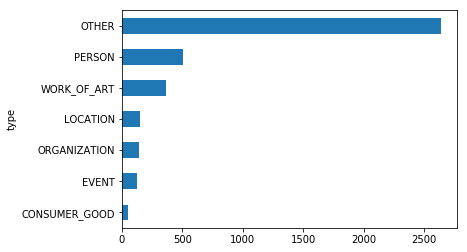

In [152]:
df.groupby(['type'])['name'].count().sort_values().plot(kind='barh')
plt.show()

### Evaluating quality
Below are the top and bottom 10 matches ranked by salience.  Ideally, the salience score is highly correlated with my notion of relevance.  If so, I should be able to identify a threshold above which I trust this service, and a threshold below which I discard results.  I'll leave you to judge for yourself based on the edge cases below.

In [155]:
df.head(10)

,name,num_mentions,salience,type,wiki_url
3886,inverse document frequency,5,0.844926,OTHER,
81,ensemble learning algorithm,5,0.826697,OTHER,
468,discussion,5,0.795514,WORK_OF_ART,
1576,central limit theorem,5,0.781171,OTHER,
1138,model diagnostic,5,0.745560,OTHER,
0,PageRank,5,0.741658,OTHER,https://en.wikipedia.org/wiki/PageRank
474,Peter Backus,5,0.736100,PERSON,
928,k-means clustering algorithm,5,0.735917,OTHER,
1275,Deepjazz,5,0.699512,OTHER,
1319,episode,5,0.699019,WORK_OF_ART,


In [156]:
df.tail(10)

,name,num_mentions,salience,type,wiki_url
3960,twitter,5,0.000712,OTHER,https://en.wikipedia.org/wiki/Twitter
3961,@tomlevenson,5,0.000712,PERSON,
3962,Penguin Random House,5,0.000711,ORGANIZATION,https://en.wikipedia.org/wiki/Penguin_Random_H...
3963,Greatest Scientist,5,0.000569,PERSON,
3964,Newton,5,0.000519,LOCATION,
3965,Berlin,5,0.000456,LOCATION,
3966,Counterfeiter: The Unknown Detective Career,5,0.000456,PERSON,
3967,TM,5,0.000456,ORGANIZATION,
3968,Worldâ,5,0.000456,ORGANIZATION,
3969,Nova,5,0.000455,ORGANIZATION,


### Location fail
I did observe that the Google Cloud Natural Language API fails pretty hard when labeling things by location.  I'll definitely forgive former guest [Sharon Hill](http://sharonahill.com/) being labeled as a city, but the rest of the results are all over the place.  Apparently RSA is a more salient location than Los Angeles County.

In [160]:
df[df['type']=='LOCATION']

,name,num_mentions,salience,type,wiki_url
1967,Microsoft Build,5,0.282605,LOCATION,https://en.wikipedia.org/wiki/Build_(developer...
3828,state,5,0.256005,LOCATION,
744,cities,5,0.231739,LOCATION,
2837,state,5,0.160156,LOCATION,
3360,city,5,0.143382,LOCATION,
2298,neighbors,5,0.120266,LOCATION,
178,US,5,0.102961,LOCATION,https://en.wikipedia.org/wiki/United_States
859,state,5,0.089733,LOCATION,
2252,Sharon Hill,5,0.088902,LOCATION,"https://en.wikipedia.org/wiki/Sharon_Hill,_Pen..."
2636,states,5,0.084390,LOCATION,


In [163]:
df.to_csv('labels.csv', sep='\t', index=False)

In [161]:
set(df['type'])

{'CONSUMER_GOOD',
 'EVENT',
 'LOCATION',
 'ORGANIZATION',
 'OTHER',
 'PERSON',
 'WORK_OF_ART'}

In [162]:
df[df['type']=='CONSUMER_GOOD']

,name,num_mentions,salience,type,wiki_url
3202,mini,5,0.243997,CONSUMER_GOOD,
3062,Machine learning models,5,0.200440,CONSUMER_GOOD,
1612,machine learning models,5,0.188068,CONSUMER_GOOD,
3036,models,5,0.132068,CONSUMER_GOOD,
746,bicycles,5,0.127677,CONSUMER_GOOD,
413,cars,5,0.096333,CONSUMER_GOOD,
443,machine,5,0.070443,CONSUMER_GOOD,
3444,machine,5,0.065068,CONSUMER_GOOD,
2923,models,5,0.062334,CONSUMER_GOOD,
3464,MINI,5,0.053786,CONSUMER_GOOD,
